<a href="https://colab.research.google.com/github/rickygrosvenor-pramanick/ray-gen/blob/main/ray_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install diffusers transformers accelerate bitsandbytes safetensors datasets peft torch torchvision safetensors huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [13]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.8 MB/s eta 0:00:00


In [19]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model, TaskType
import torch
import os
import glob
import pandas as pd
import pydicom
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
unet = UNet2DConditionModel.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="unet").to(device)
lora_cfg = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,  # generic fallback
    inference_mode=False,
    r=4,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["to_q","to_k","to_v"]
)
unet_lora = get_peft_model(unet, lora_cfg).to(device)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [9]:
!pip install --quiet kaggle

In [10]:
from google.colab import drive, files
from pathlib import Path
import shutil

drive.mount('/content/drive')


# 1) Upload the file
uploaded = files.upload()  # select kaggle.json here

# 2) Move it into place
Path("/root/.kaggle").mkdir(parents=True, exist_ok=True)
shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")
!chmod 600 /root/.kaggle/kaggle.json

# 3) Download & unzip
!kaggle competitions download -c rsna-pneumonia-detection-challenge -p /content/rsna-data
!unzip -q "/content/rsna-data/*.zip" -d /content/rsna-data


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving kaggle.json to kaggle.json
 99% 3.61G/3.66G [00:09<00:00, 725MB/s]
100% 3.66G/3.66G [00:09<00:00, 415MB/s]


In [16]:
# adjust if your unzip path differs
IMG_DIR   = "/content/rsna-data/stage_2_train_images"
LABEL_CSV = "/content/rsna-data/stage_2_train_labels.csv"

# Read the CSV
df = pd.read_csv(LABEL_CSV)
print("Total rows:", len(df))
df.head()

OUT_DIR = "/content/rsna-png"
os.makedirs(OUT_DIR, exist_ok=True)

def dicom_to_png(dcm_path, out_path):
    ds = pydicom.dcmread(dcm_path)
    arr = ds.pixel_array
    img = Image.fromarray(arr).convert("L")
    img.save(out_path)

# Example: convert first 100 for sanity check
for idx, row in df.head(100).iterrows():
    pid = row['patientId']
    dcm_path = os.path.join(IMG_DIR, f"{pid}.dcm")
    png_path = os.path.join(OUT_DIR, f"{pid}.png")
    dicom_to_png(dcm_path, png_path)

labels = df.groupby('patientId')['Target'].max().reset_index()
labels.columns = ['patientId', 'label']
labels.head()

Total rows: 30227


,patientId,label
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,000924cf-0f8d-42bd-9158-1af53881a557,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,1
3,000fe35a-2649-43d4-b027-e67796d412e0,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1


In [17]:
train_df, val_df = train_test_split(labels, test_size=0.1, stratify=labels['label'], random_state=42)
print("Train:", len(train_df), "Val:", len(val_df))

Train: 24015 Val: 2669


In [18]:
class RSNADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid  = self.df.loc[idx, 'patientId']
        lbl  = self.df.loc[idx, 'label']
        img_path = os.path.join(self.img_dir, f"{pid}.dcm")
        ds = pydicom.dcmread(img_path)
        img = Image.fromarray(ds.pixel_array).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(lbl, dtype=torch.long)

# transforms: resize, to tensor, normalize
tfms = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

train_ds = RSNADataset(train_df, IMG_DIR, transform=tfms)
val_ds   = RSNADataset(val_df,   IMG_DIR, transform=tfms)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

(np.float64(-0.5), np.float64(2057.5), np.float64(1029.5), np.float64(-0.5))

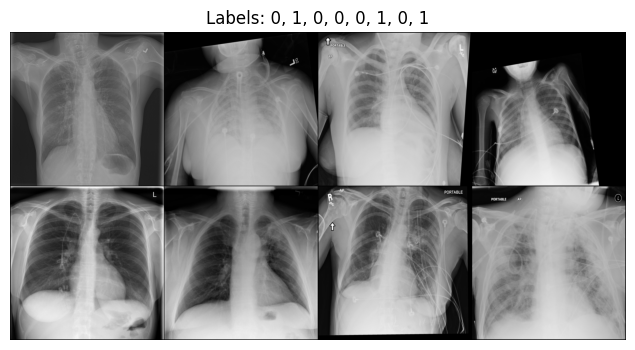

In [20]:
# show a batch
imgs, lbls = next(iter(train_loader))
grid = torchvision.utils.make_grid(imgs[:8], nrow=4, normalize=True)
plt.figure(figsize=(8,4))
plt.imshow(grid.permute(1,2,0))
plt.title("Labels: " + ", ".join(map(str,lbls[:8].tolist())))
plt.axis('off')